In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas
import geopandas as gpd
from geopandas.tools import sjoin

from shapely.geometry import Point

from scipy.interpolate import interp1d

import datetime

from tqdm import tqdm
import networkx as nx
import sys
sys.path.insert(1, '../graph_construction/')
from WI_graph_functions import *

In [15]:
# Read in needed data
WILakes  = pd.read_pickle("../graph_construction/WILakes.df")
WIRivers = pd.read_pickle("../graph_construction/WIRivers.df")
agland   = pd.read_pickle("../graph_construction/agland.df")

HUC8  = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC8/HUC8.shp")
HUC10 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC10/HUC10.shp")
HUC12 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC12/HUC12.shp")

WItofroms       = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms.csv")
WItofroms_lakes = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_lakes.csv")
WItofroms_agg   = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_agg.csv")

WI    = gpd.GeoDataFrame.from_file("../graph_construction/lakes_rivers/WI/WI.shp")
CAFOS = gpd.GeoDataFrame.from_file("../graph_construction/CAFOS_shp/CAFOS_shp.shp")

In [16]:
# Read in the lake index data for the DNR
lake_index = pd.read_csv("../DNR_data/lake_index_WBIC_COMID.csv")

### Read in DNR data and take the average TP and chlorophyll-a measurement

In [17]:
# Define GeoDataframes and Dataframes to hold data
WILakes_sub = WILakes.copy(deep=True)
WILakes_sub["TPavg"] = 0
WILakes_sub["chlaavg"] = 0
lakegdf = gpd.GeoDataFrame(columns=WILakes_sub.columns)

lake_index["TPavg"]   = 0
lake_index["chlaavg"] = 0

# Define counters to determine how many lakes have a certain limit of data to them
counter = 0
counter5 = 0

# Loop through the lake index; for each waterbody, read in the corresponding DNR data
for i in tqdm(range(len(lake_index))):
    lake_num = lake_index.lake_index.iloc[i]
    comid = lake_index.COMID.iloc[i]
    DNR = pd.read_csv(f"../DNR_data/Lakes/Lake{lake_num}/DNR_data.csv")
    DNR.date = pd.to_datetime(DNR.date)
    
    # If the DNR data has an associated COMID, save the data if there are
    # 50+ data points for TP and 50+ data points for chlorophyll-a
    if lake_index.COMID.iloc[i] != 0:
        
        if len(DNR.TP[DNR.TP.notna()& (DNR.TP != "ND*")]) >5 and len(DNR.chla[DNR.chla.notna()& (DNR.chla != "ND*")]) > 5:
            counter5 += 1

        if len(DNR.TP[DNR.TP.notna()& (DNR.TP != "ND*")]) >50 and len(DNR.chla[DNR.chla.notna()& (DNR.chla != "ND*")]) > 50:
            counter += 1
            lakegdf = lakegdf.append(WILakes_sub[WILakes_sub.COMID == comid])
            lakegdf.TPavg.iloc[-1]     = np.average(DNR.TP.values[DNR.TP.notna() & (DNR.TP != "ND*")].astype(float))
            lakegdf.chlaavg.iloc[-1]   = np.average(DNR.chla.values[DNR.chla.notna()& (DNR.chla != "ND*")].astype(float))
            lake_index.TPavg.iloc[i]   = np.average(DNR.TP.values[DNR.TP.notna() & (DNR.TP != "ND*")].astype(float))
            lake_index.chlaavg.iloc[i] = np.average(DNR.chla.values[DNR.chla.notna()& (DNR.chla != "ND*")].astype(float))

100%|████████████████████████████████████████████████████████████████████████████████| 871/871 [00:12<00:00, 68.39it/s]


In [18]:
# Build the original graphs of waterbodies and rivers
G_lakes = build_graph(WItofroms_lakes)

In [19]:
# Add CAFOs to the graph and get data for plotting
G_CAFOS = add_CAFOS_to_graph(G_lakes, WILakes, WIRivers, CAFOS)

G_CAFOS_pos, node_colors_CAFOS, node_size_CAFOS = get_pos_dict_with_pollutant(G_CAFOS, WILakes, WIRivers, CAFOS)

100%|████████████████████████████████████████████████████████████████████████████| 46245/46245 [10:38<00:00, 72.42it/s]


### Define the waterbodies that are most and least polluted

In [20]:
# Get the set of waterbodies that are most and least polluted
eut_lake_index = lake_index[(lake_index.TPavg>110) & (lake_index.chlaavg>30)]
cln_lake_index = lake_index[(lake_index.TPavg<10.8) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]

# Get the unique list of COMIDs for most polluted and least polluted lakes
eut_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg>110) & (lake_index.chlaavg>30)]).astype(int)
cln_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg<10.8) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]).astype(int)

# Get the set of all nodes in the graph with CAFOs
G_CAFOS_nodes = [i for i in G_CAFOS.nodes]

# Get the set of waterbodies that are most and least polluted AND are in the graph 
eut_node_index = eut_lake_index[eut_lake_index.COMID.isin(G_CAFOS_nodes)]
cln_node_index = cln_lake_index[cln_lake_index.COMID.isin(G_CAFOS_nodes)]

# Get the unique set of waterbodies that are most and least polluted AND are in the graph 
eut_nodes = np.intersect1d(eut_COMIDs, G_CAFOS_nodes).astype(int)
cln_nodes = np.intersect1d(cln_COMIDs, G_CAFOS_nodes).astype(int)

### Build a function to plot the most and least polluted waterbodies

In [21]:
def make_cs2_fig(ax, node, G, G_pos, lake_name, lake_tp, lake_chla, lake_gdf=WILakes, river_gdf=WIRivers, node_size = 4, arrowsize=5, CAFOS=CAFOS):
    # Define a function to get the GeoDataFrames of interest. Similar to the plotting functions of case study 1
    def get_gdfs(G, comid, lake_gdf=lake_gdf, river_gdf=river_gdf, HUC12 = HUC12, HUC10=HUC10, agland=agland):
        all_nodes = [i for i in G.nodes]
        all_nodes = all_nodes + [comid]
        rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
        lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
        
        huc12_rivs  = [i for i in rivers.huc12.values]
        
        huc12_lakes = [i for i in lakes.huc12.values]
        huc12_vals = huc12_lakes + huc12_rivs
        huc2       = lake_gdf.huc2[lake_gdf.COMID == comid].iloc[0]
        
        
        huc12_vals = [i for i in huc12_vals if i > huc2*1e10 and i < (huc2*1e10 + 1e10 - 1)]
        huc10_vals = [i for i in lakes.huc10.values]
        huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
        huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]

        #aglands    = gpd.overlay(agland, huc12s,how="intersection")
        #print("done with overlay")
        
        aglands = agland[agland.huc12.isin(huc12_vals)]
        
        return lakes, rivers, huc12s, aglands
    
    
    # Get the upstream graph for a given node
    g, cols = get_upstream_graph(G, node, lake_gdf, river_gdf)
    
    # Get the important dataframes for a given node
    lakes, rivers, huc12s, aglands = get_gdfs(g, node)

    # Get the huc12s of interest
    huc12_vals = huc12s.huc12.values
    
    # Get the agricultural land fraction
    land_frac = sum(aglands.area)/sum(huc12s.area)
    
    # Plot the lakes
    aglands.plot(ax=ax, color="forestgreen")
    huc12s.plot(ax=ax, color="none", edgecolor="black")
    lakes.plot(ax=ax, color="skyblue")
    nx.draw_networkx(g,pos=G_pos,node_size=node_size,with_labels=False,ax=ax,arrowsize=arrowsize,node_color=cols)
    
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #if False:
    #    WI.plot(ax=ax, color="none", edgecolor="black")
    if True:
        WILakes[WILakes.COMID == node].centroid.plot(ax=ax, markersize=350,marker="*", color="gold",edgecolors="black",linewidth = 1,zorder=151)
    if len(CAFOS[CAFOS.huc12.isin(huc12_vals)]) > 0:
        CAFOS[CAFOS.huc12.isin(huc12_vals)].centroid.plot(ax=ax, markersize=10, color="orange",marker="s", zorder=150)
        #WILakes[WILakes.COMID == comid].plot(ax=ax, color="red")

    return land_frac
        
    #ax.set_title(f"{lake_name} \nTP avg = {np.round(lake_tp,1)} "+ r"$mg/m^3$" +f"\nchla avg = {np.round(lake_chla,1)} " +r"$mg/m^3$"+f"\nAg Land = {np.round(land_frac*100,1)} %",fontsize= 12,loc='left')
        

### Plot the most and least polluted waterbodies

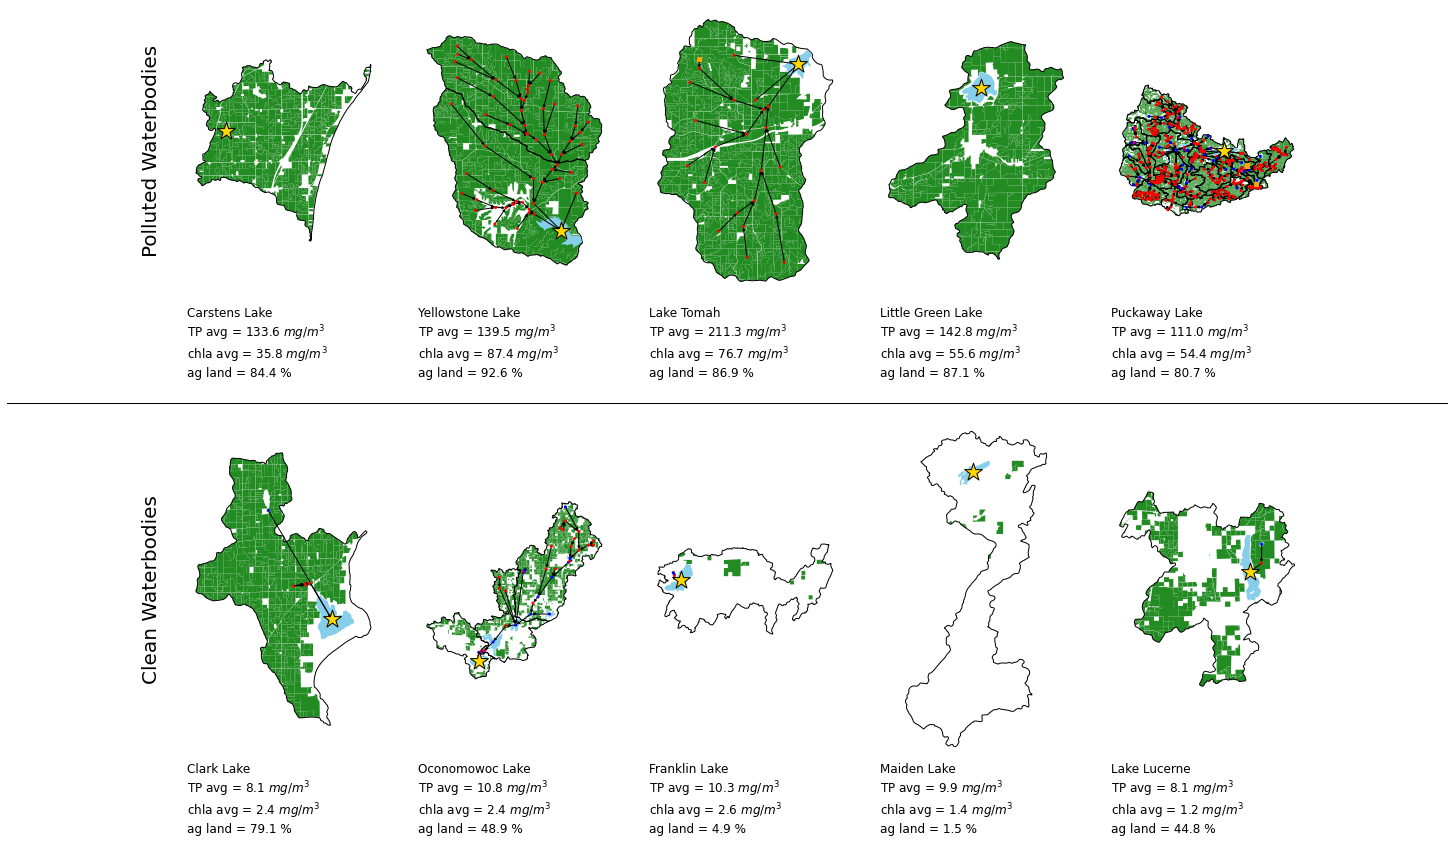

In [22]:
fig, ax = plt.subplots(6,5,figsize=(20,16), gridspec_kw={"height_ratios":[4,.1, .1, 4, .3, .1]})#[.001,4,.0001,.001,4]})

for i in range(5):
    lake_vals = eut_node_index[eut_node_index.COMID == eut_nodes[i]]
    
    lake_name = lake_vals.lakename.iloc[0]
    lake_TP   = lake_vals.TPavg.iloc[0]
    lake_chla = lake_vals.chlaavg.iloc[0]
    
    land_frac = make_cs2_fig(ax[0,i], eut_nodes[i], G_CAFOS, G_CAFOS_pos,lake_name, lake_TP, lake_chla)
    ax[2,i].set_title(f"{lake_name} \nTP avg = {np.round(lake_TP,1)} "+ r"$mg/m^3$" +f"\nchla avg = {np.round(lake_chla,1)} " +r"$mg/m^3$"+f"\nag land = {np.round(land_frac*100,1)} %",fontsize= 12,loc='left')
    ax[2,i].set_axis_off()
    ax[1,i].set_axis_off()
    
for j in range(5):
    
    lake_vals = cln_node_index[cln_node_index.COMID == cln_nodes[j]]
    
    
    lake_name = lake_vals.lakename.iloc[0]
    lake_TP   = lake_vals.TPavg.iloc[0]
    lake_chla = lake_vals.chlaavg.iloc[0]
    
    land_frac = make_cs2_fig(ax[3,j], cln_nodes[j], G_CAFOS, G_CAFOS_pos,lake_name, lake_TP, lake_chla)
    ax[5,j].set_title(f"{lake_name} \nTP avg = {np.round(lake_TP,1)} "+ r"$mg/m^3$" +f"\nchla avg = {np.round(lake_chla,1)} " +r"$mg/m^3$"+f"\nag land = {np.round(land_frac*100,1)} %",fontsize= 12,loc='left')
    ax[5,j].set_axis_off()
    ax[4,j].set_axis_off()
    
ax[0,0].set_ylabel(f"Polluted Waterbodies\n",fontsize=20)
ax[3,0].set_ylabel(f"Clean Waterbodies\n",fontsize=20)
line = plt.Line2D([0,1],[.51,.51], color="black", linewidth=1)
fig.add_artist(line)
#plt.savefig("Test.pdf")
plt.show()

### Define a function to get the metrics for several of the most and least polluted waterbodies. 

In [23]:
def get_cs2_metrics(node_list, graph):
    
    # Define a function to get the agricultural land fraction
    def get_ag_frac(all_nodes, lake_gdf, river_gdf, agland, HUC12, HUC10, comid):
        rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
        lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
        
        huc12_rivs  = [i for i in rivers.huc12.values]
        
        huc12_lakes = [i for i in lakes.huc12.values]
        huc12_vals = huc12_lakes + huc12_rivs
        huc2       = lake_gdf.huc2[lake_gdf.COMID == comid].iloc[0]
        huc12_node = lake_gdf.huc12[lake_gdf.COMID == comid].iloc[0]
        #print(huc2)
        #print(huc12_vals)
        
        #if node == 6866527:
        #    huc12s = huc12s[huc12s.huc12 < 50000000000]
        
        # This line tests whether the huc12 code that the waterbody lies in geographically matches the 
        # huc2 code from which it comes. There are a few waterbodies that are listed in a given huc2 but lie
        # outside based on the watershed boundary dataset;
        if huc12_node > huc2*1e10 and huc12_node < (huc2*1e10 + 1e10 -1):
            huc12_vals = [i for i in huc12_vals if (i > huc2*1e10 and i < (huc2*1e10 + 1e10 - 1))]
            
        huc10_vals = [i for i in lakes.huc10.values]
        aglands    = agland[agland.huc12.isin(huc12_vals)]
        huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
        huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
        
        #aglands    = gpd.overlay(agland, huc12s,how="intersection")
        
        aglands = agland[agland.huc12.isin(huc12s.huc12.values)]
        
        return sum(aglands.area)/sum(huc12s.area)
    
    # Define counters to keep track of the metrics of interest
    count_CAFOS        = 0
    count_not_in_graph = 0
    count_in_graph     = 0
    count_ag_frac50    = 0
    count_ag_frac80    = 0
    count_10_nodes     = 0
    count_50_nodes     = 0
    count_headwater    = 0
    tot                = len(node_list)
    
    # Define the nodes in the graph
    gnodes = [i for i in graph.nodes]
    
    # Define a list to fill with agricultural land fractions
    ag_fracs = []
    
    # Loop through a list of nodes to get the metrics for
    for k, node in enumerate(node_list):
            # If the node is in the overall graph 
        if np.isin(node, gnodes):
            # Count that the node is in the graph 
            count_in_graph += 1
            # Get the upstream node
            g, cols = get_upstream_graph(graph, node, WILakes, WIRivers)
            subnodes = [i for i in g.nodes]
            
            # Indicator as to whether a CAFO was counted; it is possible that it would be counted 
            # in the headwater test and later on in the test
            counted_CAFO = 0
            # If the waterbody is the only thing in the graph, it is a headwater
            if len(np.unique([n for n in subnodes if not (np.isin(n, CAFOS.Node.values))])) == 1:
                count_headwater += 1
                
                huc12_val = WILakes.huc12[WILakes.COMID == node].iloc[0]
                
                # Count if it's attached to a CAFO
                if len(CAFOS[CAFOS.huc12 == huc12_val]) > 0:
                    count_CAFOS += 1
                    counted_CAFO += 1
            
            # Get the agricultural land fraction 
            ag_frac_val = get_ag_frac(subnodes + [node], WILakes, WIRivers, agland, HUC12, HUC10, node)
            ag_fracs    = np.append(ag_fracs, ag_frac_val)
            
            # Count if agricultural land fraction is > 50%
            if ag_frac_val > .5:
                count_ag_frac50 += 1
                
            # Count if agricultural land fraction is > 80%
            if ag_frac_val > .8:
                count_ag_frac80 += 1
                
            # Count if there are more than 10 nodes upstream 
            if len(subnodes) > 10:
                count_10_nodes += 1
            
            # Count if there are more than 50 nodes upstream 
            if len(subnodes) > 50:
                count_50_nodes += 1
                
            # Loop through the graph and see if there are CAFOs upstream
            if counted_CAFO == 0:
                for i in subnodes:
                    if np.isin(i, CAFOS.Node.values):
                        count_CAFOS += 1
                        break
            
        else:
            # Count not in graph 
            count_not_in_graph += 1
            huc12_val = WILakes.huc12[WILakes.COMID == node].iloc[0]
            
            # Count if there's a CAFO in the huc12
            if len(CAFOS[CAFOS.huc12 == huc12_val]) > 0:
                count_CAFOS += 1
                
            # Count for agricultural land
            ag_frac_val = get_ag_frac([node], WILakes, WIRivers, agland, HUC12, HUC10, node)
            if ag_frac_val > .5:
                count_ag_frac50 += 1
                
            if ag_frac_val > .8:
                count_ag_frac80 += 1
            ag_fracs = np.append(ag_fracs, ag_frac_val)
                
    print()
    print("The number of lakes connected to CAFOS is             ", count_CAFOS, "  ", count_CAFOS/tot)
    print("The number of lakes not in the graph is               ", count_not_in_graph, "   ", count_not_in_graph/tot)
    print("The number of lakes in the graph is                   ", count_in_graph, "   ", count_in_graph/tot)
    print("The number of lakes that are headwaters is            ", count_headwater, "   ", count_headwater/tot)
    print("The number of lakes with a 50% ag fraction is         ", count_ag_frac50, "   ", count_ag_frac50/tot)
    print("The number of lakes with a 80% ag fraction is         ", count_ag_frac80, "   ", count_ag_frac80/tot)
    print("The number of lakes connected to 10 upstream nodes is ", count_10_nodes, "   ", count_10_nodes/tot)
    print("The number of lakes connected to 50 upstream nodes is ", count_50_nodes, "   ", count_50_nodes/tot)
    print()
    print("The average agricultural land fraction is ", np.average(ag_fracs))
    
    return ag_fracs
    

### Get the metrics for the polluted and less polluted waterbodies

In [24]:
eut_general_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg>60) & (lake_index.chlaavg>15)]).astype(int)
cln_general_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg<15) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]).astype(int)


In [25]:
ag_frac_eut = get_cs2_metrics(eut_general_COMIDs, G_CAFOS)


The number of lakes connected to CAFOS is              6    0.3333333333333333
The number of lakes not in the graph is                3     0.16666666666666666
The number of lakes in the graph is                    15     0.8333333333333334
The number of lakes that are headwaters is             2     0.1111111111111111
The number of lakes with a 50% ag fraction is          17     0.9444444444444444
The number of lakes with a 80% ag fraction is          6     0.3333333333333333
The number of lakes connected to 10 upstream nodes is  9     0.5
The number of lakes connected to 50 upstream nodes is  6     0.3333333333333333

The average agricultural land fraction is  0.7304966904560609


In [26]:
ag_frac_cln = get_cs2_metrics(cln_general_COMIDs, G_CAFOS)


The number of lakes connected to CAFOS is              4    0.06666666666666667
The number of lakes not in the graph is                36     0.6
The number of lakes in the graph is                    24     0.4
The number of lakes that are headwaters is             10     0.16666666666666666
The number of lakes with a 50% ag fraction is          28     0.4666666666666667
The number of lakes with a 80% ag fraction is          4     0.06666666666666667
The number of lakes connected to 10 upstream nodes is  3     0.05
The number of lakes connected to 50 upstream nodes is  1     0.016666666666666666

The average agricultural land fraction is  0.4170867803282569
